In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Introduction to GANs

In this notebook you will build a GAN from scratch, grossly following the DCGAN architecture. 

**Goals:**


1.   Build a GAN arhictecture from scratch
2.   Write the GAN loss function and train GAN from scratch
3.   Have experience with some of the instability problems inherent with training GANs.
4.   [Bonus] Extend the unconditional GAN into a conditional GAN. 



## 1. Getting Started

We will work with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. It contains 60,000 images size 28x28 of handwritten digits, from 0 to 9.

## 1. Dataloading

### 1.1 Define some hyperparameters and transforms


In [ ]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='/home/datadrive', download=True, transform=mytransform)

In [ ]:
dataloader = DataLoader(dataset=mnist_train, 
                         batch_size=batch_size,
                         shuffle=True)    

In [ ]:
# plot some images
real_batch, real_labels = next(iter(dataloader))

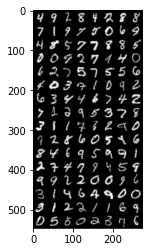

In [ ]:
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))

## 2. Model Architecture

We will follow the general architecture of a DCGAN - or deep convolutional GAN. This [influential paper](https://arxiv.org/pdf/1511.06434v2.pdf) produced much of the foundation for modern GANs and how to train them.

(GANs are notoriously **hard** to train, we will try to get a feeling why in this notebook.)

## 2.1. The Generator



The generator performs subsequent upsampling blocks, transforming a latent vector shaped [batch_size, latent_size] into an image (values in [-1, 1]).

The generator block will consists of:
- Transpose Convolution
- Batch Norm 
- ReLU


Complete the function `get_upscaling_block`. Then, use the function to define our model defined as follows:

Input: Random "noise" $z$ shaped `[n_batch, n_z]`

Output: Generated image size `[n_batch, 1, 32, 32]` in range [-1, 1]

1. Reshape z into `[n_batch, n_z, 1, 1]` to make it into an "image"
2. First upscaling block $\rightarrow$ `[n_batch, ngf*4, 4, 4]`
3. Second upscaling block $\rightarrow$ `[n_batch, ngf*2, 8, 8]`
4. Third upscaling block $\rightarrow$ `[n_batch, ngf, 16, 16]`
5. Fourth (and last) upscaling block $\rightarrow$ `[n_batch, 1, 32, 32]`

In [ ]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and ReLU, 
    except the last block (which is only followed by tanh)
    '''
    if last_layer:
        return nn.Sequential(nn.ConvTranspose2d(channels_in,channels_out,kernel_size=kernel,stride=stride,padding=padding,bias=False),
                nn.Tanh())
    else:
        return nn.Sequential(nn.ConvTranspose2d(channels_in,channels_out,kernel_size=kernel,stride=stride,padding=padding,bias=False),
                nn.BatchNorm2d(channels_out),
                nn.ReLU())


class Generator(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()

        self.model = nn.Sequential( get_upscaling_block(nz, ngf*4, 4, 1, 0),
                                    get_upscaling_block(ngf * 4, ngf * 2, 4, 2, 1),
                                    get_upscaling_block(ngf * 2, ngf, 4, 2, 1),
                                    get_upscaling_block(ngf, nchannels, 4, 2, 1, last_layer=True)
        )
        
        ###################
        
    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2) # give spatial dimensions to z
        return self.model(x)
    
    
###########  
#         #
# BONUS:  #
#         #
###########


'''
The conditional generator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the generator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized 

'''

class ConditionalGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, nchannels=1):
        super().__init__()
        
        self.upscaling_z = nn.Sequential(*get_upscaling_block(nz, ngf*8, 4, 1, 0))
        self.upscaling_c = nn.Sequential(*get_upscaling_block(nc, ngf*8, 4, 1, 0))
        

        self.rest_model = nn.Sequential(get_upscaling_block(ngf*16, ngf*8, 4, 2, 1),
                                        get_upscaling_block(ngf*8, ngf*4, 4, 2, 1),
                                        get_upscaling_block(ngf*4, nchannels, 4, 2, 1, last_layer=True)
        )
        
        
    def forward(self, x, y):
        x = x.unsqueeze(2).unsqueeze(2)
        y = y.unsqueeze(2).unsqueeze(2)
        
        x = self.upscaling_z(x)
        y = self.upscaling_c(y)
        
        x = torch.cat([x, y], dim=1)
        
        return self.rest_model(x)
        

### 2.1.3. Sanity Tests

In [ ]:
nz = 1000
z = torch.randn(batch_size, nz)

In [ ]:
G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

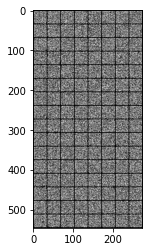

In [ ]:
# visualize the output - at first it should just look like random noise!!
x_fake = G(z)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

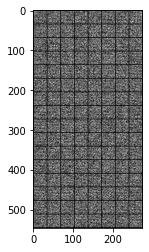

In [ ]:
# UNCOMMENT FOR CONDITIONAL GENERATOR SANITY CHECKING

z = torch.randn(batch_size, nz)
y = F.one_hot(real_labels).float()

cG = ConditionalGenerator(nz=nz, ngf=16, nc=10)
x_fake = cG(z, y)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

## 2.2. The discriminator

The discriminator will be a mirror image of the generator. 

### 2.2.2 Discriminator Architecture

The discriminator will also use a fully convolutional architecutre, with each block consisting of:
- Conv layer
- BatchNorm
- ReLU

Complete the function `get_downscaling_block` and then use it to define the following architecture for the discriminator:

Input: Image shaped `[n_batch, 1, 32, 32]` (in [-1, 1])
Output: Discriminator scores `[n_batch, 1]` in range [0, 1]

1. First downscaling block $\rightarrow$ `[n_batch, ndf, 16, 16]`
2. Second downscaling block $\rightarrow$ `[n_batch, ndf*2, 8, 8]`
3. Third downscaling block $\rightarrow$ `[n_batch, ndf*4, 4, 4]`
4. Last downscaling block $\rightarrow$ `[n_batch, 1]` 

In [ ]:
def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):
    
    if is_last:
        return nn.Sequential(nn.Conv2d(channels_in,channels_out,kernel_size=kernel,stride=stride,padding=padding,bias=False),
                nn.Sigmoid())
    
    elif not use_batch_norm:
        return nn.Sequential(nn.Conv2d(channels_in,channels_out,kernel_size=kernel,stride=stride,padding=padding,bias=False),
                nn.LeakyReLU(0.2))
    
    else:
        return nn.Sequential(nn.Conv2d(channels_in,channels_out,kernel_size=kernel,stride=stride,padding=padding,bias=False),
                nn.BatchNorm2d(channels_out),
                nn.LeakyReLU(0.2))
    
    


class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super().__init__()
        

        self.model = nn.Sequential( get_downscaling_block(nchannels, ndf, 4, 2, 1),
                                    get_downscaling_block(ndf, ndf * 2, 4, 2, 1),
                                    get_downscaling_block(ndf*2, ndf*4, 4, 2, 1),
                                    get_downscaling_block(ndf*4, 1, 4, 1, 0, is_last=True) 
        )
        


    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1) # remove spatial dimensions
    

    
###########  
#         #
# BONUS:  #
#         #
###########


'''
The conditional discriminator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the discriminator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized 

'''
    
class ConditionalDiscriminator(nn.Module):
    def __init__(self, ndf, nc, nchannels=1):
        super().__init__()
        self.downscale_x = nn.Sequential(*get_downscaling_block(nchannels, ndf*2, 4, 2, 1, use_batch_norm=False))
        self.downscale_y = nn.Sequential(*get_downscaling_block(nc, ndf*2, 4, 2, 1, use_batch_norm=False))
        

        
        self.rest = nn.Sequential(get_downscaling_block(ndf*4, ndf*8, 4, 2, 1),
                                  get_downscaling_block(ndf*8, ndf*16, 4, 2, 1),
                                  get_downscaling_block(ndf*16, 1, 4, 1, 0, is_last=True))
        
        
    def forward(self, x, y):

        size = x.shape[2]
        x = self.downscale_x(x)
        y = y.unsqueeze(2).unsqueeze(2).repeat(1, 1, size, size)
        y = self.downscale_y(y)
        
        x = torch.cat([x, y], dim=1)

        return self.rest(x).squeeze(1).squeeze(1) # remove spatial dimensions

### 2.2.3 Sanity Checking

In [ ]:
real_batch, real_labels = next(iter(dataloader))

In [ ]:
D = Discriminator(ndf=32, nchannels=1)
assert D(real_batch).shape == (real_batch.shape[0], 1)

In [ ]:
# Uncomment for Conditional Discriminator Sanity Checking

cD = ConditionalDiscriminator(ndf=32, nc=10, nchannels=1)
assert cD(real_batch, F.one_hot(real_labels).float()).shape == (real_batch.shape[0], 1)

# 3. Training

## 3.1 Loss 
The essential thing to remember is that the logistic and the non-saturating logistic GAN losses can be written exclusively using the [binary cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Our GAN loss will be defined ONLY using the following criterion:



In [ ]:
criterion = nn.BCELoss() # we will build off of this to make our final GAN loss!

## 3.2 Helper functions

We will need a few helper functions. 
1. First, we need to continuously sample z from a Gaussian distribution. 
2. Secondly, we need to make our "ground-truth" labels when using the BCE loss. This should output vectors of either 0s or 1s. 

In [ ]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1) 
    return r.to(device)


# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

## 3.3 Creating the optimizers and hyperparameters

The original DCGAN paper shows that Adam works well in the generator and the discriminator with a learning rate of 0.0002 and Beta1 = 0.5.

Define your optimizers

In [ ]:
nz = 1000
ngf = 32
ndf = 32

nchannels= 1 
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))


## 3.3 Training!

Now for the fun part, training! 
Training a GAN consists in making an update to the discriminator, then the generator.
Training a GAN requires BABYSITTING!! Remember that many things can go wrong when training a GAN:
- The discriminator is too strong for the generator - the generator cannot improve. 
- The generator easily fools the discriminator - cannot learn.
- Mode collapse - generator is not capable of generating diverse images.

it: 0; g_loss: 0.9389617443084717; d_loss: 0.8473010063171387; avg_real_score: 0.4304579496383667; avg_fake_score: 0.5393664836883545: : 0it [00:00, ?it/s]

generated images


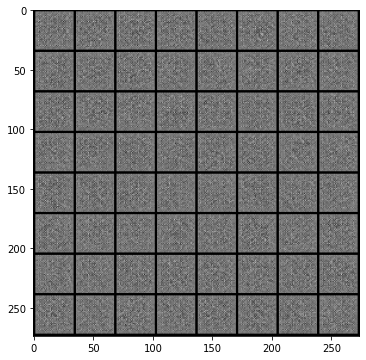

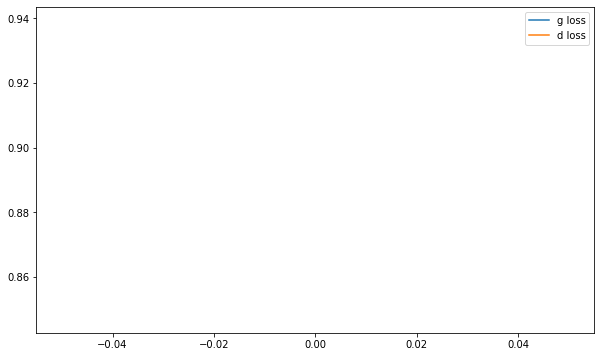

it: 200; g_loss: 2.0445797443389893; d_loss: 0.23739250004291534; avg_real_score: 0.7549748420715332; avg_fake_score: 0.1402031034231186: : 200it [00:20, 10.22it/s]

generated images


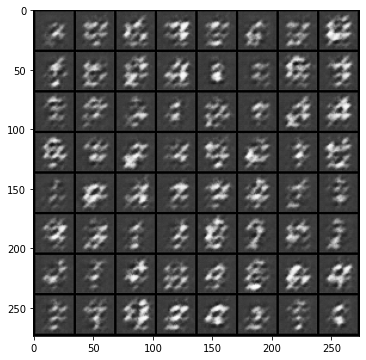

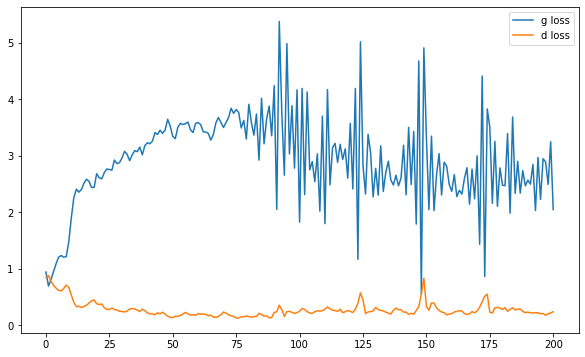

it: 400; g_loss: 1.7604987621307373; d_loss: 0.1412992775440216; avg_real_score: 0.7922845482826233; avg_fake_score: 0.03226446360349655: : 400it [00:40,  9.83it/s]

generated images


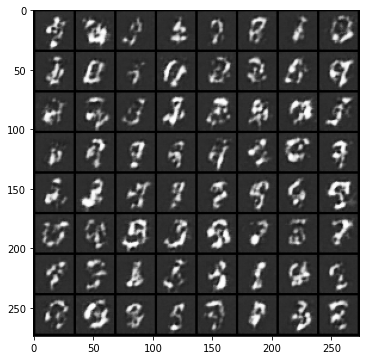

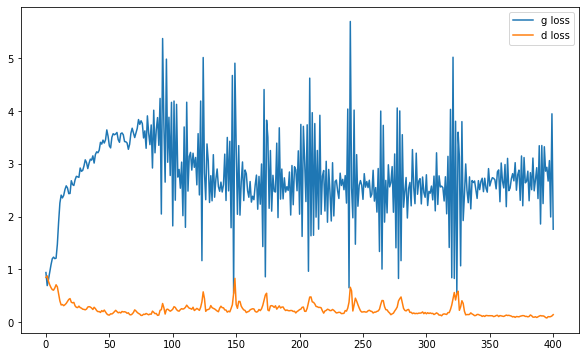

it: 468; g_loss: 2.5837647914886475; d_loss: 0.1143413558602333; avg_real_score: 0.8627976179122925; avg_fake_score: 0.06866803765296936: : 469it [00:48,  9.68it/s]
it: 469; g_loss: 3.020998477935791; d_loss: 0.09628400206565857; avg_real_score: 0.9392635226249695; avg_fake_score: 0.11630552262067795: : 0it [00:00, ?it/s]

generated images


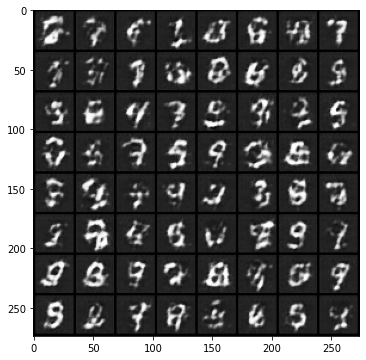

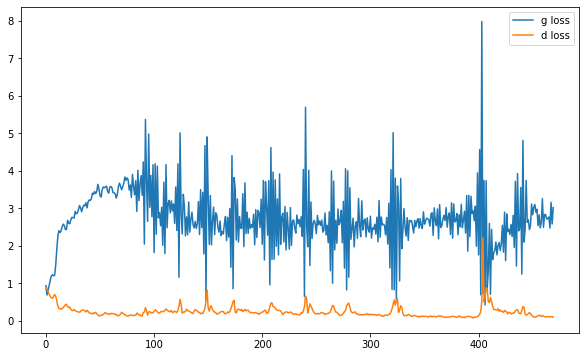

it: 669; g_loss: 3.5348188877105713; d_loss: 0.1332366019487381; avg_real_score: 0.9723191261291504; avg_fake_score: 0.19930751621723175: : 199it [00:21,  9.66it/s] 

generated images


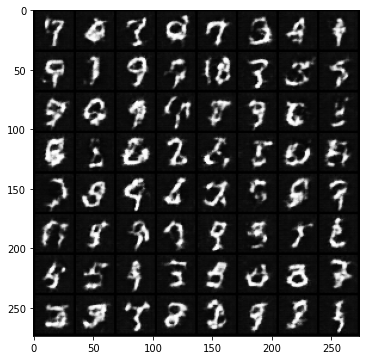

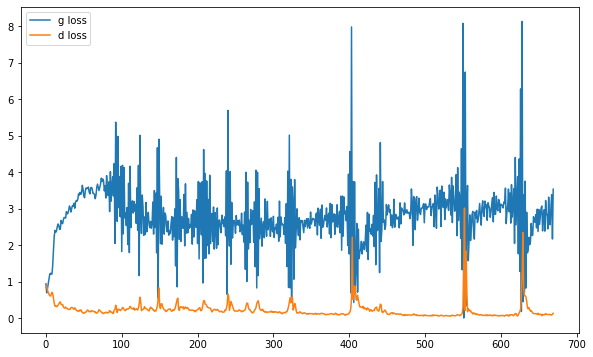

it: 869; g_loss: 1.7280305624008179; d_loss: 0.17954227328300476; avg_real_score: 0.7911880016326904; avg_fake_score: 0.10015708953142166: : 399it [00:42,  9.65it/s]

generated images


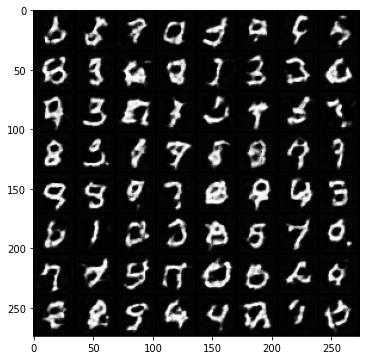

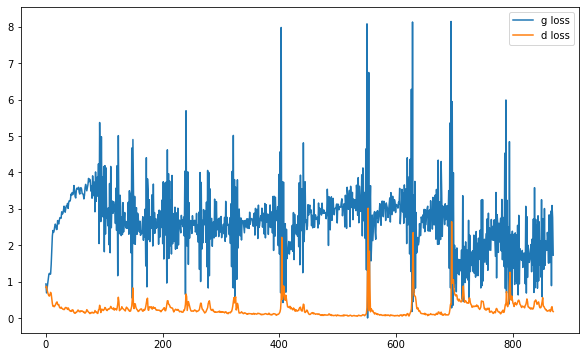

it: 937; g_loss: 1.236917495727539; d_loss: 0.349385142326355; avg_real_score: 0.5871302485466003; avg_fake_score: 0.11830395460128784: : 469it [00:49,  9.38it/s]
it: 938; g_loss: 1.6857467889785767; d_loss: 0.3095915913581848; avg_real_score: 0.8043330907821655; avg_fake_score: 0.3019046187400818: : 0it [00:00, ?it/s]

generated images


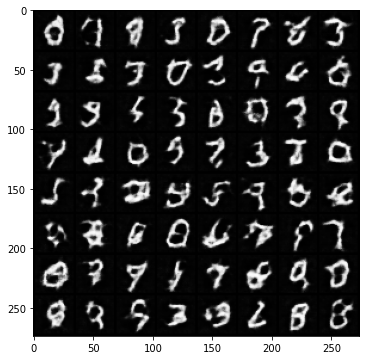

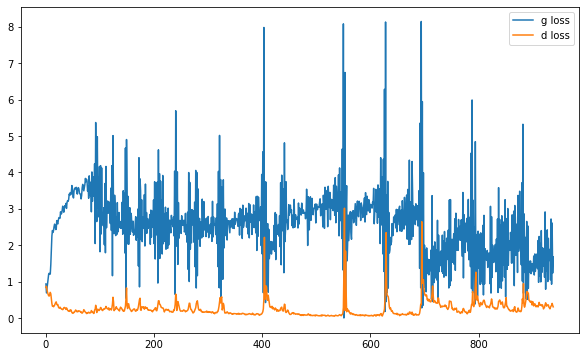

it: 1138; g_loss: 1.4939749240875244; d_loss: 0.41993844509124756; avg_real_score: 0.5499303936958313; avg_fake_score: 0.13770440220832825: : 200it [00:22,  9.60it/s]

generated images


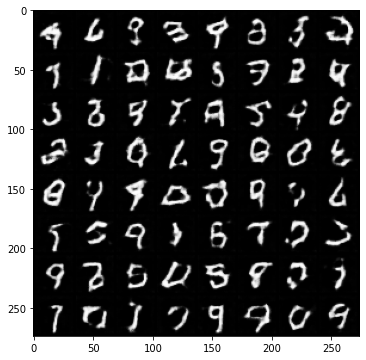

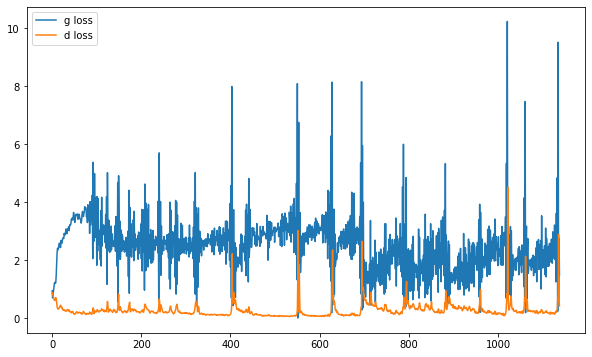

it: 1338; g_loss: 1.7713959217071533; d_loss: 0.16011099517345428; avg_real_score: 0.8028833866119385; avg_fake_score: 0.08018304407596588: : 400it [00:44,  9.18it/s]

generated images


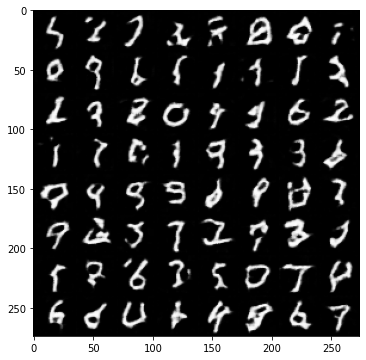

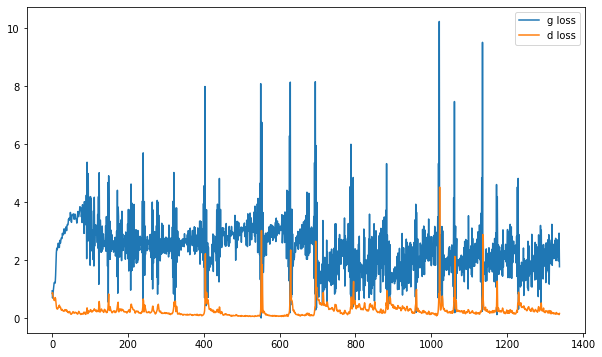

it: 1406; g_loss: 2.773069381713867; d_loss: 0.45745962858200073; avg_real_score: 0.9244425296783447; avg_fake_score: 0.5315561294555664: : 469it [00:52,  9.00it/s]
it: 1407; g_loss: 1.43988037109375; d_loss: 0.3511437773704529; avg_real_score: 0.5856635570526123; avg_fake_score: 0.0984225869178772: : 0it [00:00, ?it/s]

generated images


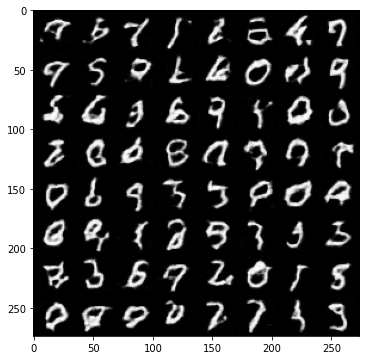

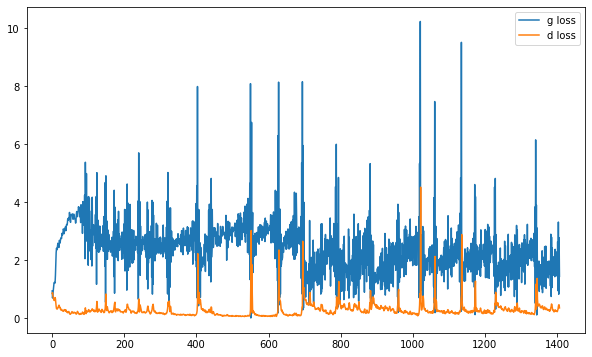

it: 1607; g_loss: 1.7961254119873047; d_loss: 0.30030494928359985; avg_real_score: 0.7743587493896484; avg_fake_score: 0.271662175655365: : 200it [00:22,  8.68it/s] 

generated images


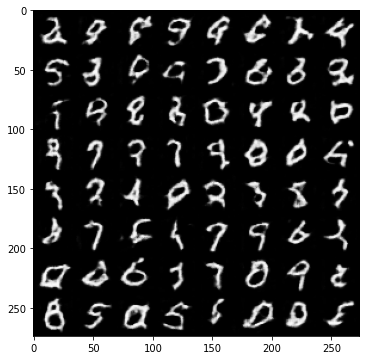

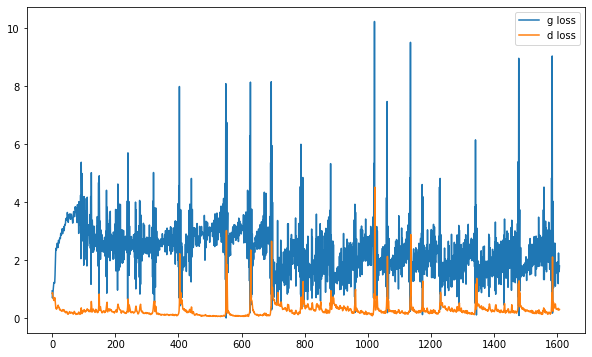

it: 1807; g_loss: 2.6586647033691406; d_loss: 0.2282131016254425; avg_real_score: 0.9070135354995728; avg_fake_score: 0.2785329818725586: : 400it [00:45,  8.92it/s]  

generated images


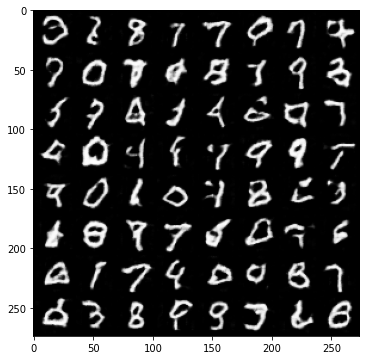

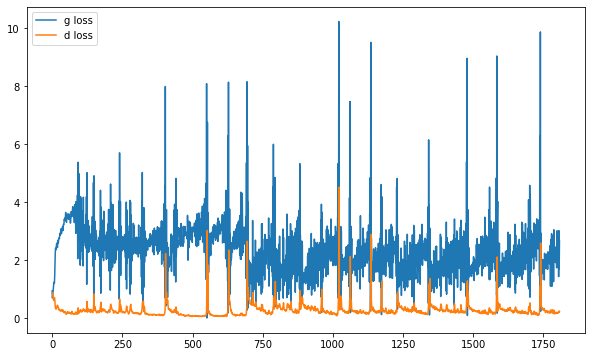

it: 1875; g_loss: 3.273716926574707; d_loss: 0.09365807473659515; avg_real_score: 0.9520260095596313; avg_fake_score: 0.12300215661525726: : 469it [00:53,  8.81it/s]
it: 1876; g_loss: 1.4310986995697021; d_loss: 0.2008802443742752; avg_real_score: 0.7376074194908142; avg_fake_score: 0.05838829278945923: : 0it [00:00, ?it/s]

generated images


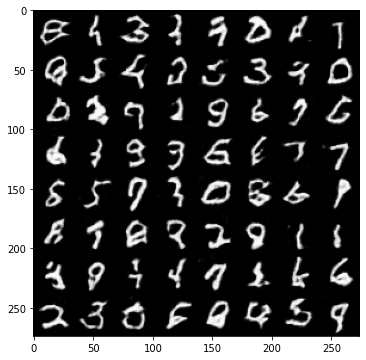

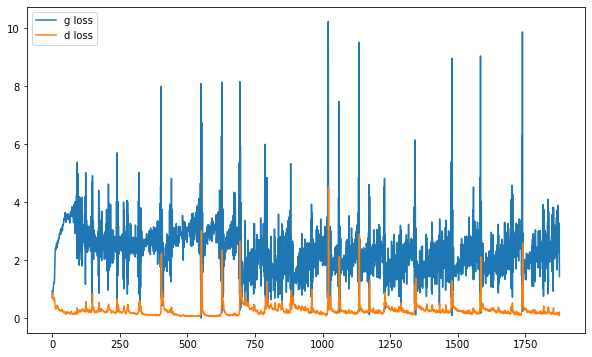

it: 2076; g_loss: 2.8817148208618164; d_loss: 0.13085398077964783; avg_real_score: 0.8906170129776001; avg_fake_score: 0.12470827996730804: : 200it [00:23,  8.61it/s]

generated images


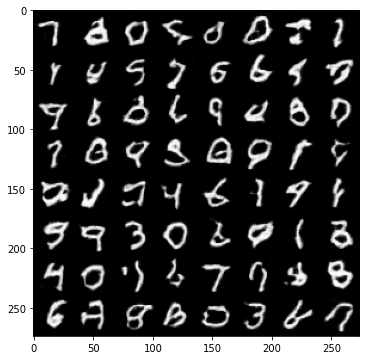

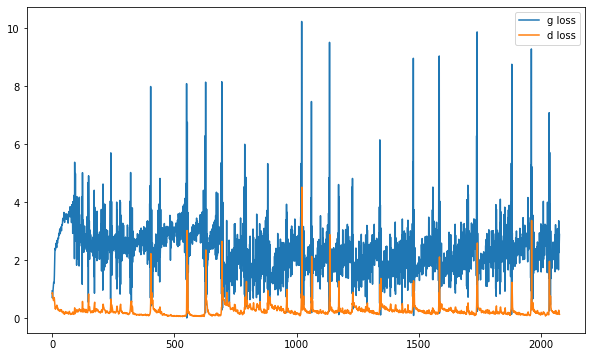

it: 2276; g_loss: 2.1082684993743896; d_loss: 0.20108361542224884; avg_real_score: 0.8113703727722168; avg_fake_score: 0.15306106209754944: : 400it [00:46,  8.73it/s]

generated images


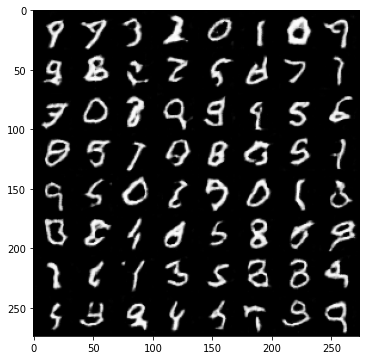

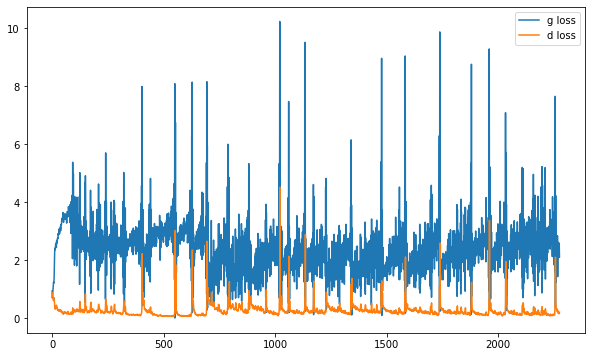

it: 2344; g_loss: 2.764455556869507; d_loss: 0.12293685227632523; avg_real_score: 0.9178379774093628; avg_fake_score: 0.13874317705631256: : 469it [00:54,  8.55it/s]


In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0] 

        one_labels = get_labels_one(cur_batch_size)
        zero_labels = get_labels_zero(cur_batch_size)

        
        # 1. sample a z vector 
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Define the real loss (for D)
        yhat_real = netD(im)
        real_loss= criterion(yhat_real, one_labels)

        # 4. Define the fake loss (for D)
        
        yhat_fake = netD(fake_im)
        fake_loss= criterion(yhat_fake, zero_labels)
        
        
        ###
        ### Discriminator
        ###
        
        d_loss = (real_loss + fake_loss)/2.        
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        
        ###
        ### Generator
        ###
    
        
        g_loss = criterion(netD(fake_im), one_labels) 
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:
            
            un_norm= renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm[:64], nrow=8)
            pil_grid = to_pil(grid)  
            
            print("generated images")
            plt.imshow(pil_grid)
            plt.show()
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1

# 3. Conditional GANs [BONUS]

A simple way to improve training performance and obtain control of the generation is to provide extra information into the Generator and the Discriminator, known as **Conditional GANs**. In this case, we will provide the class label (digit number of MNIST) into both the generator and the discriminator. This will help both of the networks.

## 3.1 Conditional Generator and Discriminator

Go back to the code and complete the ConditionalDiscriminator and ConditionalGenerator classes using your GAN building blocks (`get_upsampling_block` and `get_downsampling_block` functions).


In [ ]:
nz = 100
ndf = 32
ngf = 32
nchannels= 1 
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

nc= 10

netD = ConditionalDiscriminator(ndf, nc, nchannels=1).to(device)
netG = ConditionalGenerator(nz, nc, ngf).to(device)
        
netG.apply(weights_init)
netD.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))



it: 0; g_loss: 2.506357192993164; d_loss: 0.9971048831939697; avg_real_score: 0.4954840838909149; avg_fake_score: 0.6085453033447266: : 0it [00:00, ?it/s]

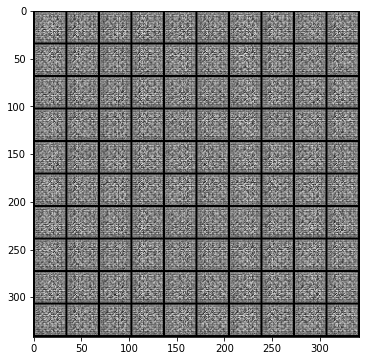

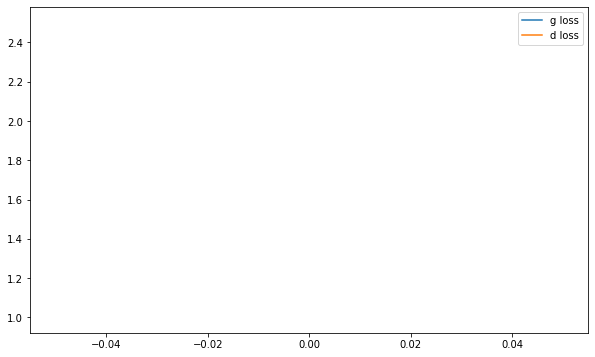

it: 200; g_loss: 1.4277960062026978; d_loss: 0.7391079664230347; avg_real_score: 0.47935405373573303; avg_fake_score: 0.4145040810108185: : 200it [01:31,  2.23it/s]

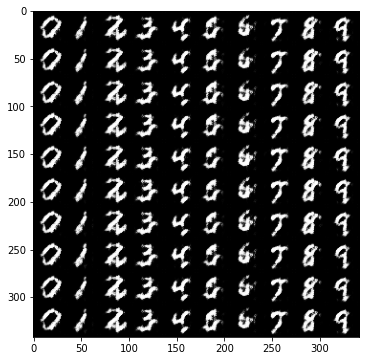

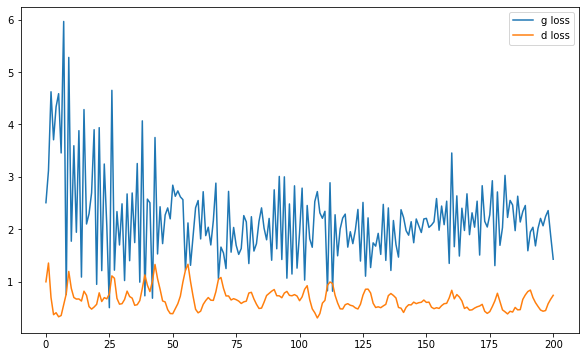

it: 400; g_loss: 2.2425806522369385; d_loss: 0.49751853942871094; avg_real_score: 0.6922730207443237; avg_fake_score: 0.38725554943084717: : 400it [03:01,  2.22it/s]

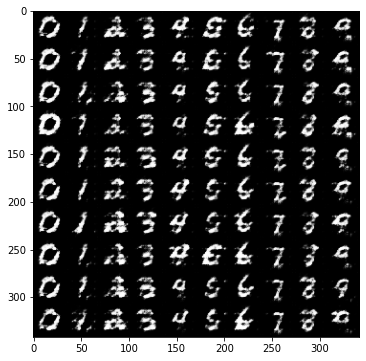

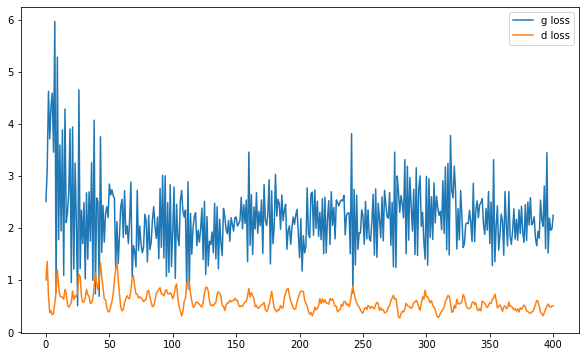

it: 468; g_loss: 2.611081838607788; d_loss: 0.5178852081298828; avg_real_score: 0.7885648608207703; avg_fake_score: 0.4687598943710327: : 469it [03:33,  2.20it/s]
it: 469; g_loss: 1.93315851688385; d_loss: 0.4999406933784485; avg_real_score: 0.5838372707366943; avg_fake_score: 0.2441278100013733: : 0it [00:00, ?it/s]

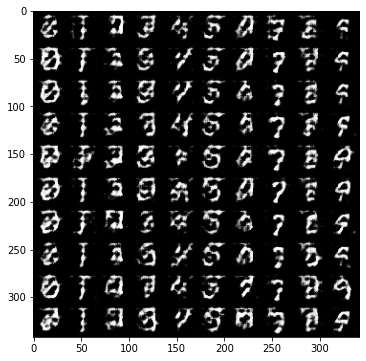

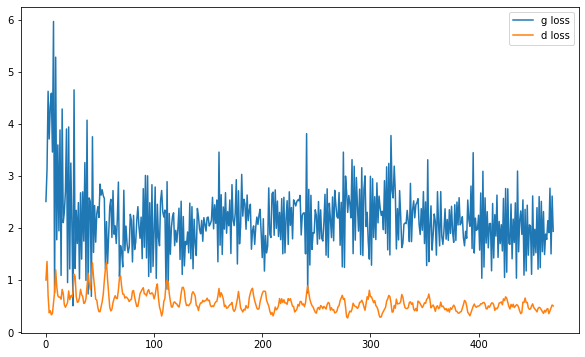

it: 669; g_loss: 0.5349174737930298; d_loss: 0.9023234248161316; avg_real_score: 0.24229446053504944; avg_fake_score: 0.10878728330135345: : 200it [01:31,  2.19it/s]

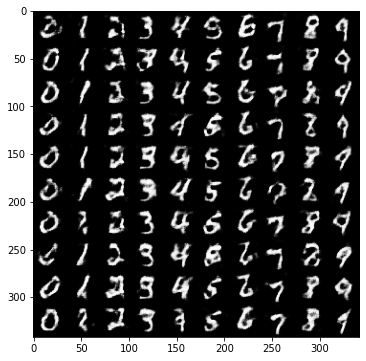

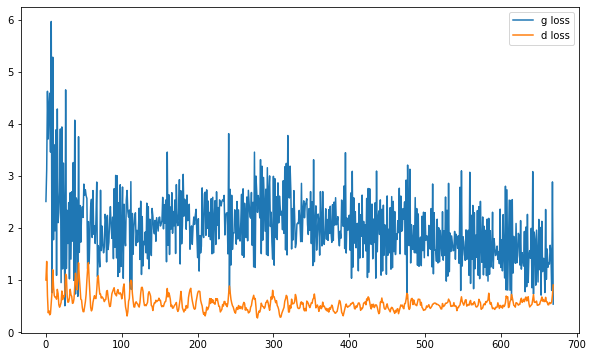

it: 869; g_loss: 1.4418306350708008; d_loss: 0.6262365579605103; avg_real_score: 0.5981848239898682; avg_fake_score: 0.47094693779945374: : 400it [03:03,  2.20it/s]

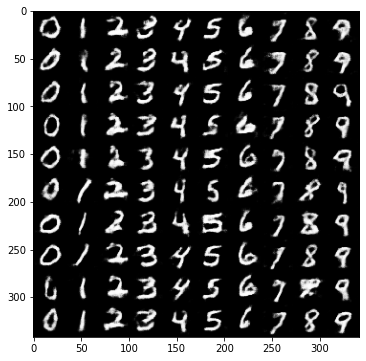

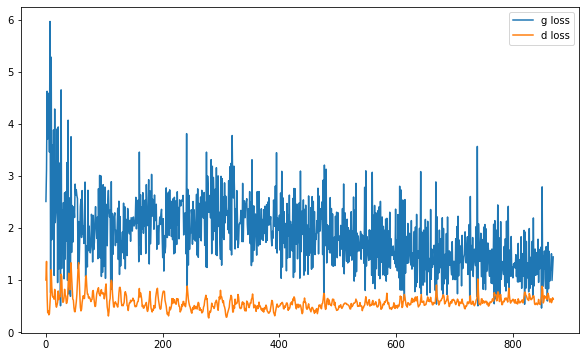

it: 937; g_loss: 1.1565542221069336; d_loss: 0.5847232937812805; avg_real_score: 0.5906326174736023; avg_fake_score: 0.41393423080444336: : 469it [03:35,  2.18it/s]
it: 938; g_loss: 1.5082948207855225; d_loss: 0.590510368347168; avg_real_score: 0.6429567337036133; avg_fake_score: 0.4648440182209015: : 0it [00:00, ?it/s]

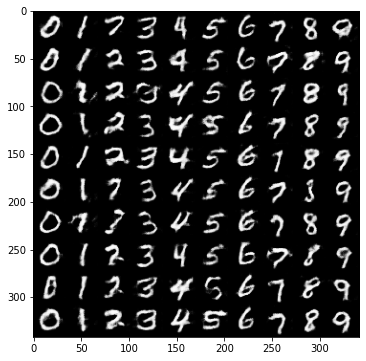

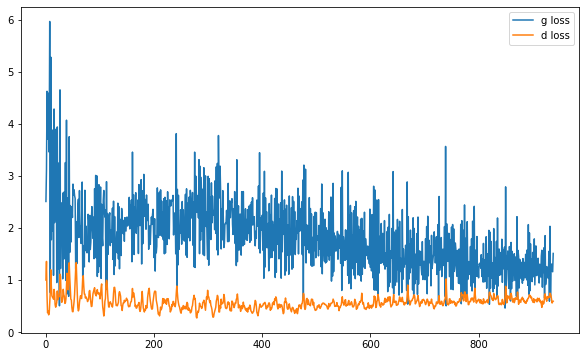

it: 1138; g_loss: 0.8671244382858276; d_loss: 0.5758827924728394; avg_real_score: 0.4984040856361389; avg_fake_score: 0.32966184616088867: : 200it [01:32,  2.20it/s]

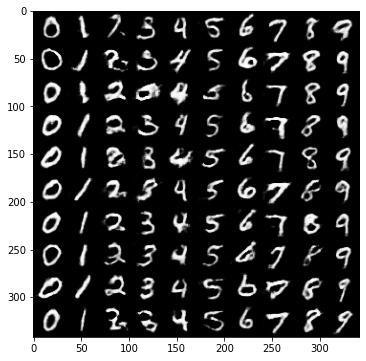

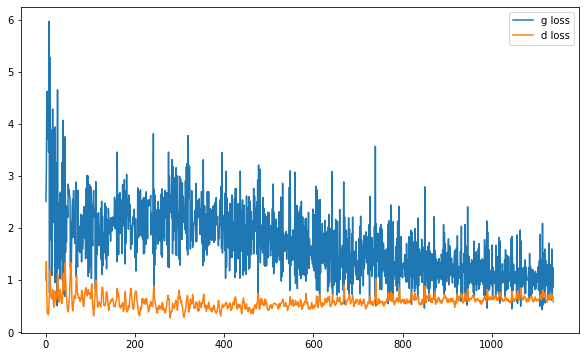

it: 1338; g_loss: 0.7710098028182983; d_loss: 0.6473380327224731; avg_real_score: 0.47592586278915405; avg_fake_score: 0.3863770663738251: : 400it [03:04,  2.20it/s]

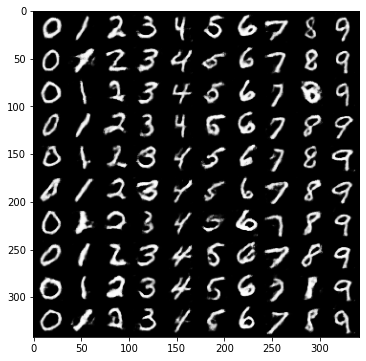

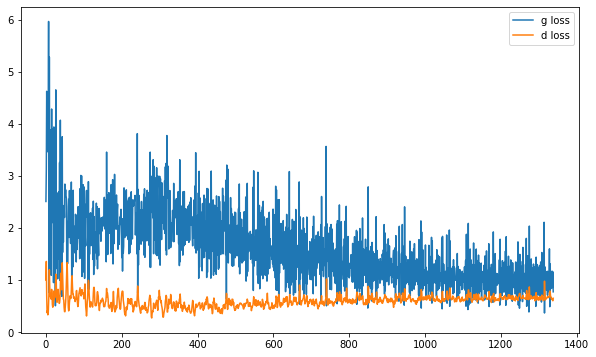

it: 1406; g_loss: 0.5754072666168213; d_loss: 0.723195493221283; avg_real_score: 0.3441886901855469; avg_fake_score: 0.2626008987426758: : 469it [03:36,  2.17it/s]
it: 1407; g_loss: 1.372889518737793; d_loss: 0.6952446699142456; avg_real_score: 0.7122843265533447; avg_fake_score: 0.6177980899810791: : 0it [00:00, ?it/s]

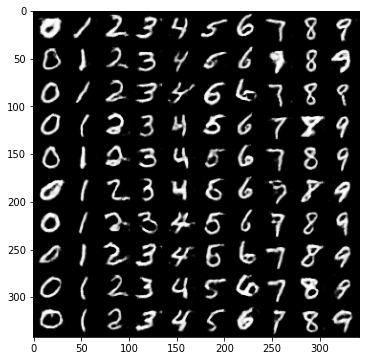

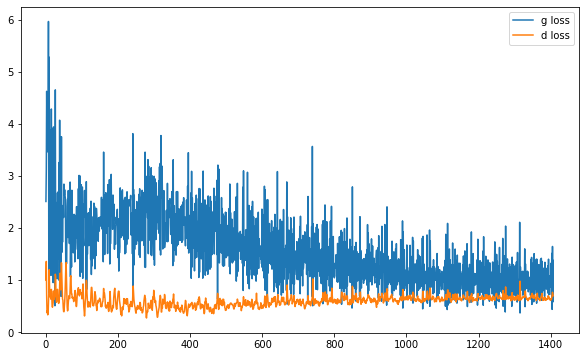

it: 1607; g_loss: 0.8236147165298462; d_loss: 0.6136294603347778; avg_real_score: 0.5293892621994019; avg_fake_score: 0.4122827649116516: : 200it [01:32,  2.18it/s]

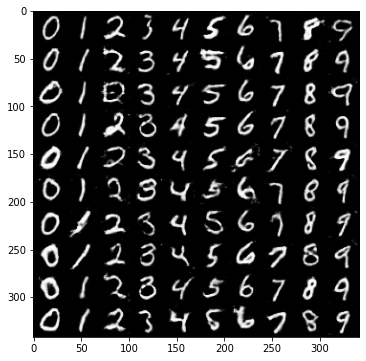

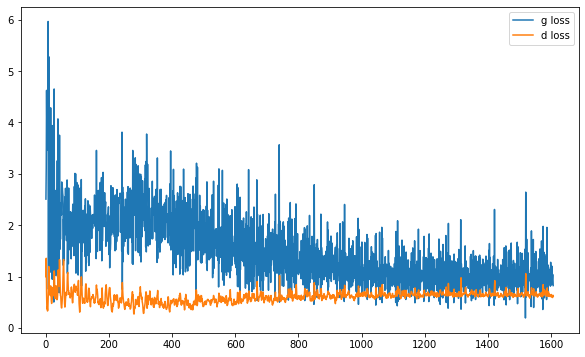

it: 1807; g_loss: 1.2342208623886108; d_loss: 0.624805212020874; avg_real_score: 0.5521085858345032; avg_fake_score: 0.4522372782230377: : 400it [03:04,  2.20it/s] 

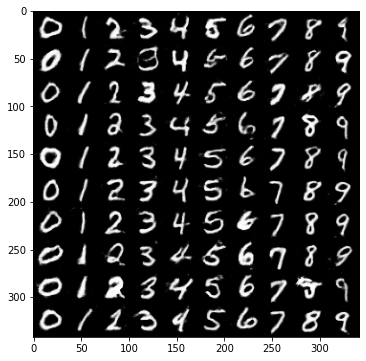

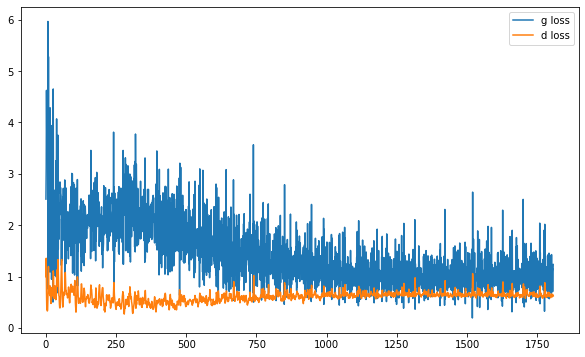

it: 1875; g_loss: 1.7956217527389526; d_loss: 0.6548314094543457; avg_real_score: 0.699042797088623; avg_fake_score: 0.589438259601593: : 469it [03:35,  2.17it/s]
it: 1876; g_loss: 0.587872326374054; d_loss: 0.6678159832954407; avg_real_score: 0.37845703959465027; avg_fake_score: 0.25427526235580444: : 0it [00:00, ?it/s]

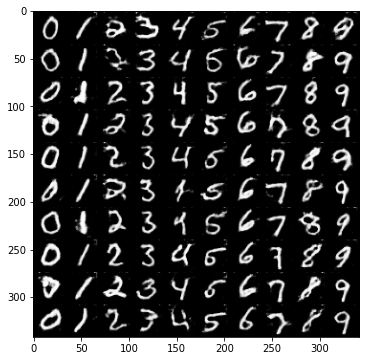

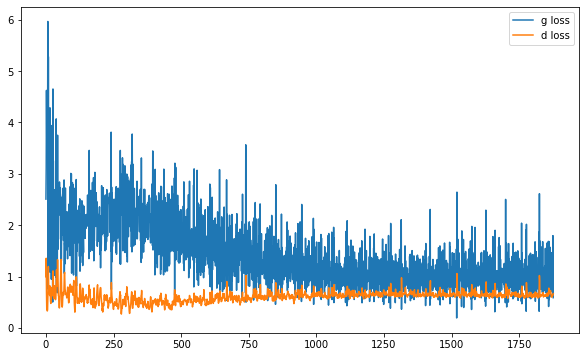

it: 2076; g_loss: 0.6632319688796997; d_loss: 0.6099597215652466; avg_real_score: 0.505413293838501; avg_fake_score: 0.3860749900341034: : 200it [01:32,  2.18it/s]  

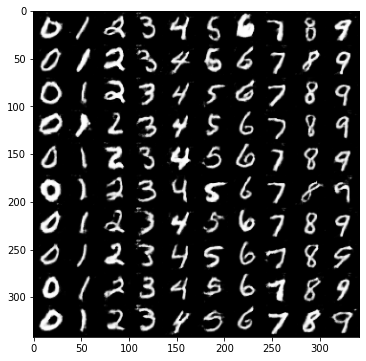

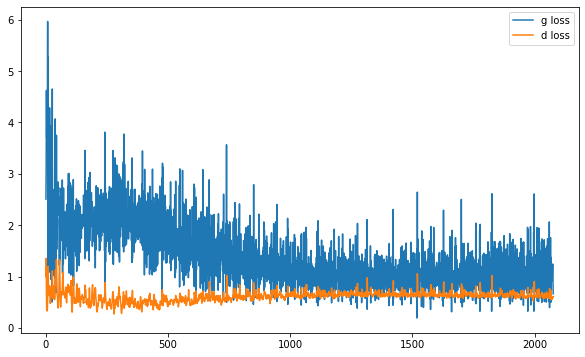

it: 2276; g_loss: 0.8734954595565796; d_loss: 0.6181326508522034; avg_real_score: 0.3877617418766022; avg_fake_score: 0.1862327605485916: : 400it [03:04,  2.19it/s]

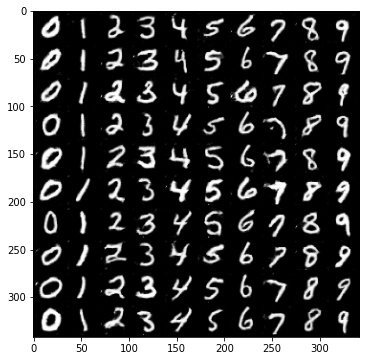

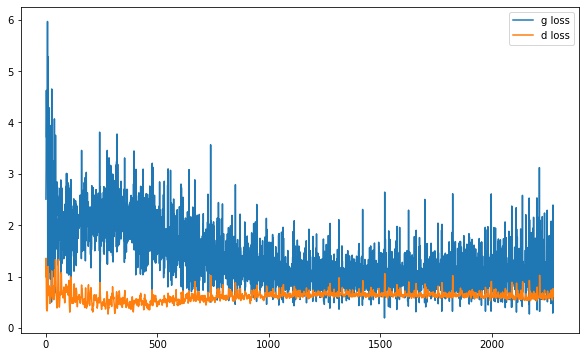

it: 2344; g_loss: 1.498884916305542; d_loss: 0.6296552419662476; avg_real_score: 0.7455856204032898; avg_fake_score: 0.5948706865310669: : 469it [03:35,  2.17it/s]


In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []

j = 0

for epoch in range(nb_epochs):
    
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, labels = batch 
        im = im.to(device)
        
        
        y = F.one_hot(labels).float().to(device)
        
        cur_batch_size = im.shape[0]  
        
        
        one_labels = get_labels_one(cur_batch_size)
        zero_labels = get_labels_zero(cur_batch_size)

        
        # 1. sample a z vector 
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z, y)

        # 3. Define the real loss (for D)
        yhat_real = netD(im, y)
        real_loss= criterion(yhat_real, one_labels)

        # 4. Define the fake loss (for D)
        
        yhat_fake = netD(fake_im, y)
        fake_loss= criterion(yhat_fake, zero_labels)
        
        
        ###
        ### Discriminator
        ###
        
        d_loss = (real_loss + fake_loss)/2.
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()
        
        
        ###
        ### Generator
        ###
        

        g_loss = criterion(netD(fake_im, y), one_labels)
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        
        if i % display_freq == 0:
            
            z = sample_z(100, nz)
            labels = torch.arange(0, 10).expand(size=(10, 10)).flatten().to(device)
            y = F.one_hot(labels).float().to(device)
            fake_im = netG(z, y)
            
            un_norm= renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=10)
            pil_grid = to_pil(grid)  
            
            plt.imshow(pil_grid)
            plt.show()
            
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1
            

# Testing
Visualization of the impact of z on generation. All digits in the same column have the same noise vector z.

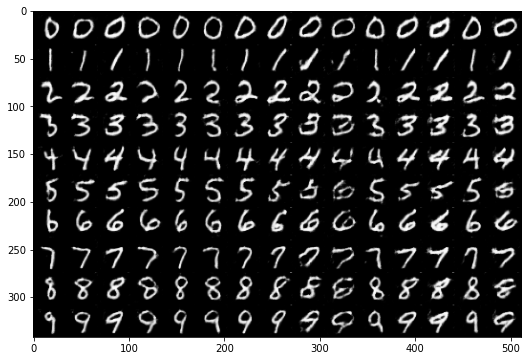

In [ ]:
n_ex = 15
n_classes = 10

z = sample_z(n_ex, nz).repeat(n_classes, 1) #.expand(10, nz)

netG.eval()

labels = torch.arange(n_classes).unsqueeze(0).reshape(-1, 1).repeat(1, n_ex).flatten().to(device)

ys = F.one_hot(labels).float()
fake_ims = netG(z, ys)

un_norm= renorm(fake_ims) # for visualization
grid = torchvision.utils.make_grid(un_norm, nrow=n_ex)
pil_grid = to_pil(grid)  

plt.imshow(pil_grid)
plt.show()
